In [1]:
# для того, чтобы скрипты гладко работали на https://colab.research.google.com/ пропишем
# установку библиотеки anaflow которую будем использовать для обратного преобразования Лапласа
!pip install anaflow

In [2]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

## 12.2. Построение и исследование решения линейного стока с использованием обратного преобразования Лапласа <a class="anchor" id="12.2"></a>

Численного обратное преобразование Лапласа удобный инструмент для построение решений уравнения фильтрации. Последующие примеры показывают как можно его использовать с python. 

In [3]:
# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_line_source(u, rd=1.):
    """
    расчет решения линейного стока для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    return np.divide(kn(0, rd * u**0.5) , u)

# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_line_source_inv(td, rd=1.):
    """
    расчет решения линейного стока для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
         должно быть числом
    результат массив массивов давления от времени
    """
    pd_inv = get_lap_inv(pd_lapl_line_source, rd=rd)
    return pd_inv(td)

In [4]:
# для сравнения приведем функции из раздела 11
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1.):
    """
    Решение линейного стока уравнения фильтрации
    td - безразмерное время, число или numpy массив, больше нуля
    rd - безразмерное расстояние, по умолчанию rd=1 - соответствует давлению на забое
         число или numpy массив
    результат массив массивов давления от времени
    """
    return -0.5 * expi(-0.25 * rd * rd / td)

#### Пример построения графиков сравнения реализаций решений линейного стока в безразмерных координатах

### Определение функции для перевода размерных и безразмерных величин

In [5]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

In [6]:
# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_finite_rw(u, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    # полезно учесть, что при u>5e5 выражение kn(1, u05) обратится в ноль и будет деление на ноль
    # но если принудительно сделать там выражение равное нулу, обратное преобразование Лапласа
    # может выдавать очень странные результаты, поэтому лучше пока оставить как есть
    u05 = u**0.5
    return np.divide(kn(0, rd * u05) , (u * u05 *  kn(1, u05)))


# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_finite_rw_inv(td, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
    результат массив массивов давления от времени
    """
    pd_inv = get_lap_inv(pd_lapl_finite_rw, rd=rd)
    return pd_inv(td)

# 12.4. Использование графиков с различными масштабами координат для анализа решений <a class="anchor" id="12.4"></a>

При анализе гидродинамических исследований широко используются графики в полулогарифмических и двойных логарифмических координатах. Также часто возникает необходимость расчета производных и отображение их на графиках. Разберем технические вопросы построения таких графиков с использованием `matplotlib`.

Для примера будем использовать решения построенные.

## 12.4.1. График в обычных координатах <a class="anchor" id="12.4.1"></a>

Нас будут интересовать как графики от расстояния, так и графики от времени. 
Мы можем нарисовать несколько графиков одновременно с использованием `matplotlib`

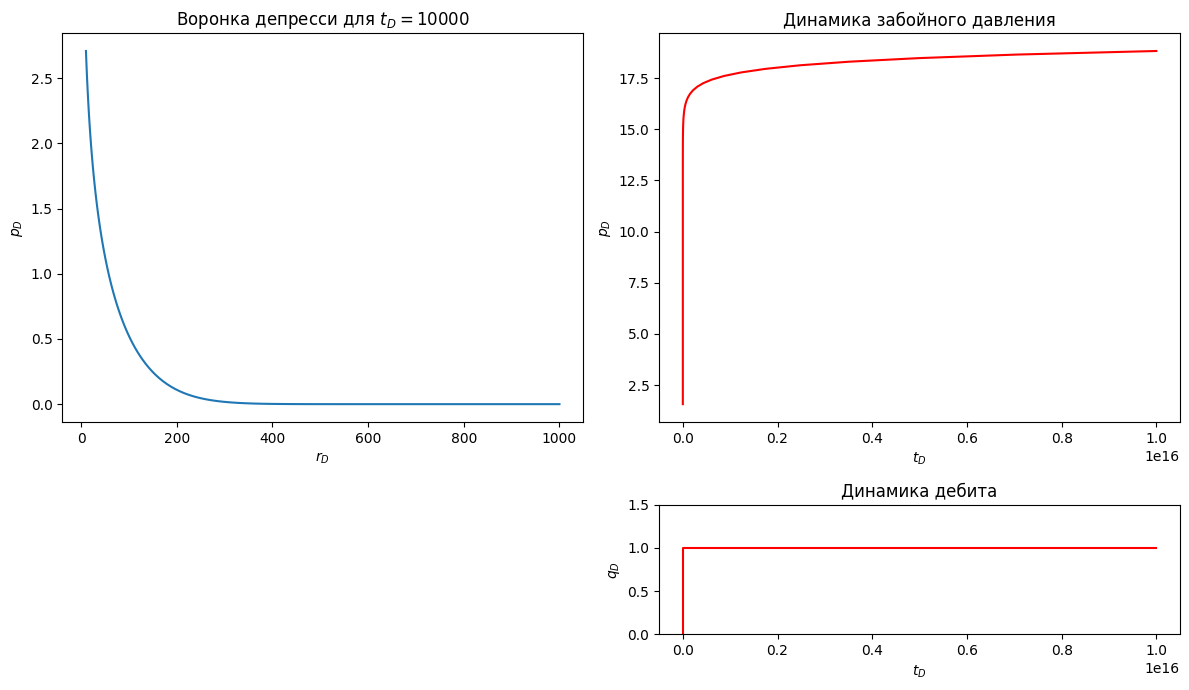

In [7]:
# задаем параметры для отрисовки отдельных графиков
td = 10000
rd = 1
# задаем массивы для отрисовки графиков - количество точек на графике
rd_arr = np.logspace(1, 3, 100)
td_arr = np.logspace(1, 16, 100)

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]})

# задаем первый график используя оси ax1
ax1.plot(rd_arr, pd_ei(td, rd_arr) )
ax1.set(title="Воронка депресси для $t_D= {}$".format(td))
ax1.set_xlabel("$r_D$")
ax1.set_ylabel("$p_D$")

# задаем первый график используя оси ax2
ax2.plot(td_arr, pd_ei(td_arr, rd), color = 'red')
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t_D$")
ax2.set_ylabel("$p_D$")

ax3.axis('off')
ax4.plot([0,0,td_arr[-1]],[0, 1, 1], color = 'red')
ax4.set(title="Динамика дебита")
ax4.set_xlabel("$t_D$")
ax4.set_ylabel("$q_D$")
ax4.set_ylim(0, 1.5)

fig.tight_layout()
plt.show()

На построенных графиках мы видем решение в обычных - декартовых координатах. Такие данные мы получим при первичном анализе замерных данных с датчиков давления при запуске скважины (красный график). Для "ручного" анализа удобно преобразовать координаты использовав факт, что построенные решение похожи на логарифм.

## 12.4.2. График в полулогарифмических координатах для безразмерного решения <a class="anchor" id="12.4.2"></a>

Графики похожие на логарифм при отображении в полулогарифмических координатах превращаются в прямую линию. Поэтому эти графики пользуются популярностью при анализе гидродинамических исследований.

Полулогарифмические координаты легко настраиваются всеми распространенными пакетами отображения. Ниже пример для `matplotlib` для решения с конечным радиусом скважины (12.22) построенным с использованием численного обратного преобразования Лапласа.

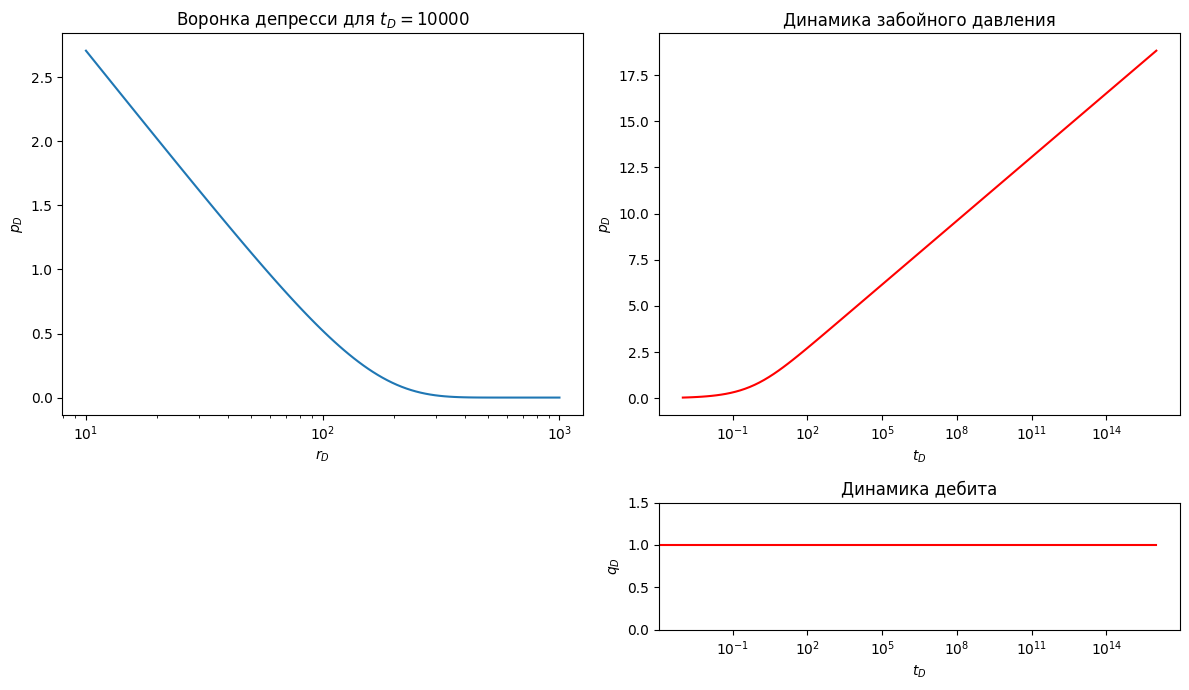

In [8]:
# задаем параметры для отрисовки отдельных графиков
td = 10000
rd = 1
# задаем массивы для отрисовки графиков - количество точек на графике
rd_arr = np.logspace(1, 3, 100)
td_arr = np.logspace(-3, 16, 100)

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]})

# задаем первый график используя оси ax1
ax1.plot(rd_arr, np.squeeze([pd_finite_rw_inv(td, ri) for ri in rd_arr]) )
ax1.set(title="Воронка депресси для $t_D= {}$".format(td))
ax1.set_xlabel("$r_D$")
ax1.set_ylabel("$p_D$")
ax1.set_xscale('log')

# задаем первый график используя оси ax2
ax2.plot(td_arr, pd_finite_rw_inv(td_arr, rd), color = 'red')
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t_D$")
ax2.set_ylabel("$p_D$")
ax2.set_xscale('log')

ax3.axis('off')
ax4.plot([0,0,td_arr[-1]],[0, 1, 1], color = 'red')
ax4.set(title="Динамика дебита")
ax4.set_xlabel("$t_D$")
ax4.set_ylabel("$q_D$")
ax4.set_ylim(0, 1.5)
ax4.set_xlim(ax2.get_xlim())
ax4.set_xscale('log')

fig.tight_layout()
plt.show()

Видно для небольших (относительно) расстояний и для больших (относительно) времен построенные решения выглядят как прямые линии, что означает, что они могут быть аппроксимированы с использованием логарифмического приближения. 

Например решение линейного стока (11.20)
$$ 
p_D(r_D,t_D) = - \frac{1}{2} Ei \left(- \dfrac{ r_D^2}{4t_d} \right) +S
\tag{12.26}
$$

может быть описаны следующим выражением 

$$ 
p_D(r_D,t_D) = - \frac{1}{2} \ln \left( \dfrac{ r_D^2}{4t_d} \right) - \frac{1}{2}\gamma +S
\tag{12.27}
$$

$$ 
p_D(r_D,t_D) = \frac{1}{2}\ln(t_d) - \left[ \frac{1}{2} \ln \left( \dfrac{ r_D^2}{4} \right) + \frac{1}{2}\gamma -S\right]
\tag{12.28}
$$
где $\gamma = 0.57721566481$ - константа Эйлера

на графике от времени в полулогарифмических координатах логарифмическое приближение выглядит как кривая с наклоном $0.5$

## 12.4.3. График в полулогарифмических координатах для безразмерного решения <a class="anchor" id="12.4.3"></a>

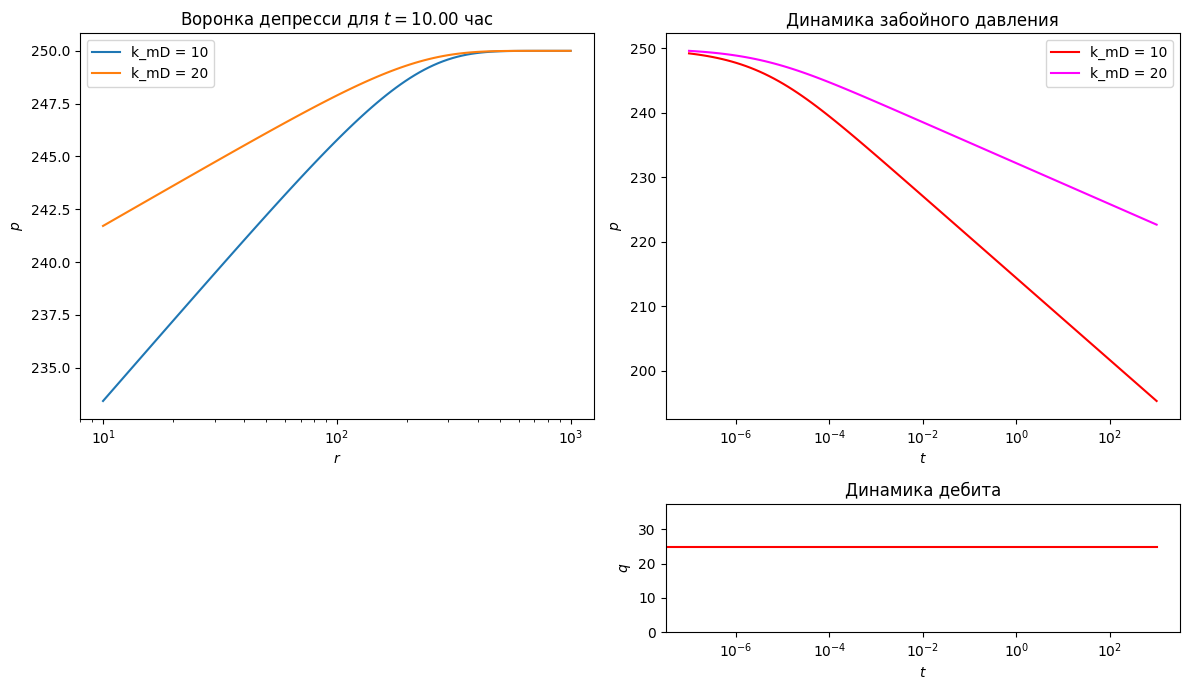

In [9]:
# задаем параметры для отрисовки отдельных графиков
t_hr = 10
rd = 1
# зададим два значения проницаемости что построить разные графики для сравнения
k_mD_1 = 10
k_mD_2 = 20
# определим дебит
q_scm3day = 25
# задаем массивы для отрисовки графиков - количество точек на графике
r_arr = np.logspace(1, 3, 100)
t_arr = np.logspace(-7, 3, 100)

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7), gridspec_kw={'height_ratios': [3, 1]})

# задаем первый график используя оси ax1
ax1.plot(r_arr, 
         p_from_pd_atma(np.squeeze([pd_finite_rw_inv(td_from_t(t_hr), ri) for ri in rd_from_r(r_arr)]), k_mD=k_mD_1, q_sm3day=q_scm3day),
         label='k_mD = {}'.format(k_mD_1))
ax1.plot(r_arr, 
         p_from_pd_atma(np.squeeze([pd_finite_rw_inv(td_from_t(t_hr), ri) for ri in rd_from_r(r_arr)]), k_mD=k_mD_2, q_sm3day=q_scm3day),
         label='k_mD = {}'.format(k_mD_2))
ax1.set(title=f"Воронка депресси для $t= {t_hr:.2f}$ час")
ax1.set_xlabel("$r$")
ax1.set_ylabel("$p$")
ax1.set_xscale('log')
ax1.legend()

# задаем первый график используя оси ax2
ax2.plot(t_arr, 
         p_from_pd_atma(pd_finite_rw_inv(td_from_t(t_arr), rd), k_mD=k_mD_1, q_sm3day=q_scm3day), color = 'red',
         label='k_mD = {}'.format(k_mD_1))
ax2.plot(t_arr, 
         p_from_pd_atma(pd_finite_rw_inv(td_from_t(t_arr), rd), k_mD=k_mD_2, q_sm3day=q_scm3day), color = 'magenta',
         label='k_mD = {}'.format(k_mD_2))
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t$")
ax2.set_ylabel("$p$")
ax2.set_xscale('log')
ax2.legend()

ax3.axis('off')
ax4.plot([0,0,t_arr[-1]],[0, q_scm3day, q_scm3day], color = 'red')
ax4.set(title="Динамика дебита")
ax4.set_xlabel("$t$")
ax4.set_ylabel("$q$")
ax4.set_ylim(0, q_scm3day*1.5)
ax4.set_xlim(ax2.get_xlim())
ax4.set_xscale('log')

fig.tight_layout()
plt.show()

На графиках в размерных переменных также радиальный приток (при котором справедливо логарифмическое приближение) отображается в виде прямых линий. 

Решение в размерных переменных можно записать как
$$
p\left(r,t\right)=p_i-\frac{18.41q_sB\mu}{kh}\left(-\frac{1}{2} Ei \left(-\frac{\varphi\mu c_tr^2}{0.00144kt}\right)+S\right) 
\tag{12.29}
$$
Приведем несколько простых арифметических преобразований (чтобы не запутаться с коэффициентами)
$$
p\left(r,t\right)=p_i-\frac{18.41q_sB\mu}{kh}\left(-\frac{1}{2} \ln \left(\frac{\varphi\mu c_tr^2}{0.00144kt}\right) -\frac{1}{2}\gamma + S\right) 
$$

$$
p\left(r,t\right)=p_i-\frac{18.41q_sB\mu}{kh}\left(\frac{1}{2} \ln \left(\frac{0.00144kt}{\varphi\mu c_tr^2}\right) -\frac{1}{2}\gamma + S\right) 
$$

$$
p\left(r,t\right)=p_i-\frac{9.205q_sB\mu}{kh}\left( \ln \left(\frac{kt}{\varphi\mu c_tr^2}\right) +ln(0.00144) -\gamma + 2S\right) 
$$

Наконец получим логарифмическое приближение для \eqref{12.29}
$$
p\left(r,t\right)=p_i-\frac{9.205q_sB\mu}{kh}\left(ln{\frac{kt}{\varphi\mu c_tr^2}}-7.12+2S\right) 
\tag{12.30}
$$

Или выделив $\ln(t)$ в явном виде получим
$$
p\left(r,t\right)=-\frac{9.205q_sB\mu}{kh}\ln(t) + \left[  p_i-\frac{9.205q_sB\mu}{kh}\left(ln{\frac{k}{\varphi\mu c_tr^2}}-7.12+2S\right) \right]
\tag{12.31}
$$

Из этого выражения видно, что определив наклон графика в полулогарифмических координатах и его смещение по вертикали мы сможем определить величины $\dfrac{9.205q_sB\mu}{kh}$ и $\left[  p_i-\dfrac{9.205q_sB\mu}{kh}\left(ln{\dfrac{k}{\varphi\mu c_tr^2}}-7.12+2S\right) \right]$ откуда чаще все находят $kh$ и $S$.

## 12.4.4. График в двойных логарифмических координатах <a class="anchor" id="12.4.4"></a>

Графики в двойных логарифмических координатах также весьма популярны при интерпретации гидродинамической модели. 

Такие графики обладают несколькими полезными свойствами. 
1. Степенные зависимости будут переводиться в прямые линии. Функция вида
$y=x^a$ при логарифмировании обоих частей равенства преобразуется к виду $ln(y) = a \cdot ln(x)$, что соответствует прямой линии на лог-лог графике с наклом $a$.
2. Зависимости вида $y = a \cdot f(b \cdot x)$ преобразуется при логарифмировании к виду $ln(y) = ln(a) + ln(f(e^{ln(b) + ln(x)})) $ или $ln(y) = ln(a) + g({ln(b) + ln(x)}) $ где $g(z) = ln(f(e^z))$. Таким образом для произвольной функции при отображении ее в лог-лог координатах множители аргумента и самой функции превращаются в сдвиги некоторой функции $g$, которая остается неизменной. За счет этого сравнивая разные изображения функций отличающихся множителями - их можно вычислить определяя величины сдвигов. 

Ниже приведен пример отображения графиков степенных функций в обычных и двойных логарифмических координатах

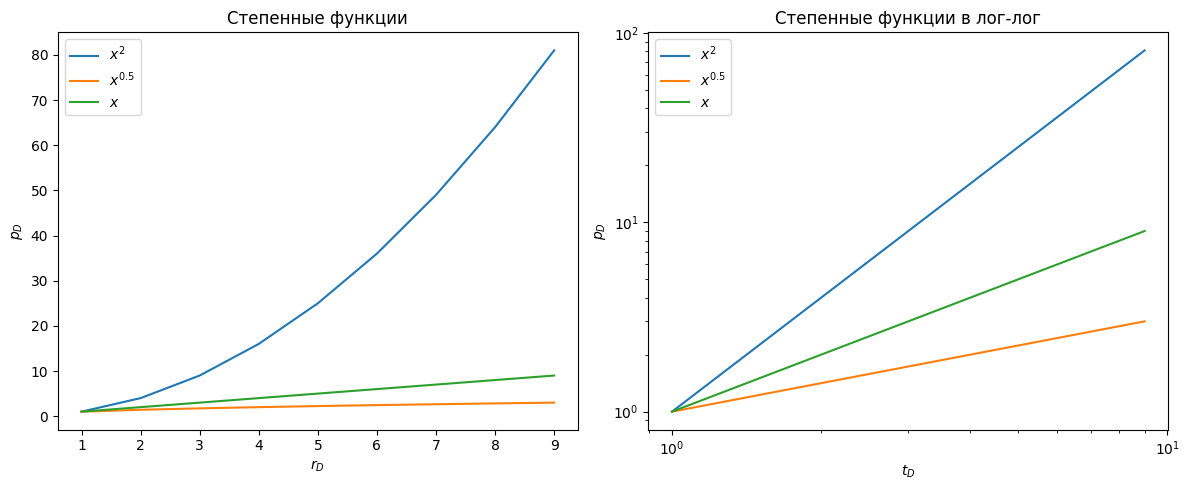

In [10]:

# задаем массивы для отрисовки графиков - количество точек на графике
rr = np.arange(1, 10, 1)


# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# задаем первый график используя оси ax1
ax1.plot(rr, rr**2 , label = '$x^2$')
ax1.plot(rr, rr**0.5, label = '$x^{0.5}$' )
ax1.plot(rr, rr**1, label = '$x$' )
ax1.set(title="Степенные функции")
ax1.set_xlabel("$r_D$")
ax1.set_ylabel("$p_D$")
ax1.legend()


# задаем первый график используя оси ax2
ax2.plot(rr, rr**2, label = '$x^2$')
ax2.plot(rr, rr**0.5, label = '$x^{0.5}$' )
ax2.plot(rr, rr**1, label = '$x$' )
ax2.set(title="Степенные функции в лог-лог")
ax2.set_xlabel("$t_D$")
ax2.set_ylabel("$p_D$")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()

fig.tight_layout()
plt.show()

## 12.4.5. Расчет и отображение значений производной функции заданной по точкам <a class="anchor" id="12.4.5"></a>

Совместно с двойными логарифмическими координатами часто применяется логарифмическая производная давления.
Численный расчет производной несложен - например можно посчитать методом конечных разностей. При использовании `numpy` массивов можно воспользоваться функцией `numpy.diff`, которая вычисляет разницу между соседними элементами массива. Тут надо учитывать, что длина массива после дифференцирования будет меньше при использовании функции `numpy.diff`. Для того чтобы посчитать производную функции `f(x)` выражение с использованием np.diff будет иметь вид `np.diff(f(x))/np.diff(x)`.

Другой вариант можно использовать функцию `numpy.gradient` куда надо передать табличные значения для дифференцирования и соответствующие значения аргумента.

При дифференцировании реальных данных полезно помнить, что операция численного дифференцирования может оказаться неустойчивой. В таких случаях необходимо применять разные виды фильтрации данных и стараться использовать более устойчивые алгоритмы численного дифференцирования (центральные разности с большим шагом и т.п.)

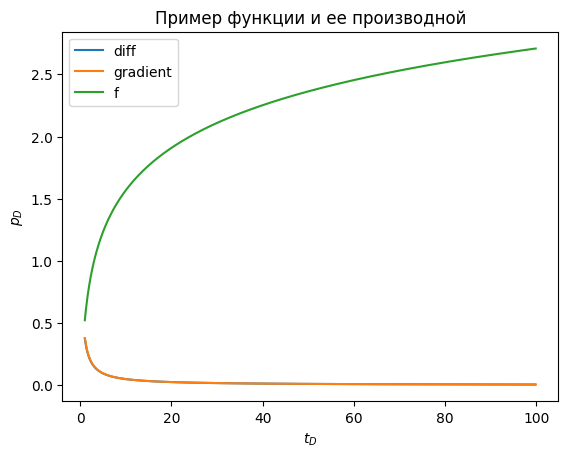

In [11]:
td = np.arange(1, 100, 0.1)
rr = 1

# при расчете разностей надо учесть, что длина массива уменьшится и убрать один элемент массива аргументов
plt.plot(td[:-1], np.diff(pd_ei(td))/np.diff(td), label='diff')
plt.plot(td, np.gradient(pd_ei(td), td), label='gradient')
plt.plot(td, pd_ei(td) , label='f')

plt.title("Пример функции и ее производной")
plt.xlabel("$t_D$")
plt.ylabel("$p_D$")
plt.legend()
plt.show()

Интересно отметить, что расчет `numpy.gradient` более универсален и проще в применении, однако простой расчет через разности немного быстрее.


In [12]:
%timeit np.diff(pd_ei(rr,td))/np.diff(td)
%timeit np.gradient(pd_ei(rr,td), td)

181 μs ± 1.35 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
215 μs ± 2.52 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Приведем сравнение двух вариантов расчета производной - разностями и с использованием `numpy.gradient` для двух наборов данных - с небольшим количеством точек (10 точек) и большим (300) для логарифмически распределенных точек

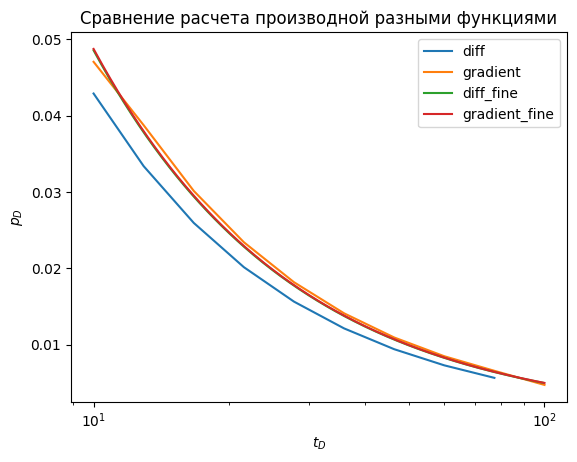

In [13]:
td = np.logspace(1, 2, 10)
td_fine = np.logspace(1, 2, 300)
rr = 1

# при расчете разностей надо учесть, что длина массива уменьшится и убрать один элемент массива аргументов
plt.plot(td[:-1], np.diff(pd_ei(td))/np.diff(td), label='diff')
plt.plot(td, np.gradient(pd_ei(td), td, edge_order=2), label='gradient')
plt.plot(td_fine[:-1], np.diff(pd_ei(td_fine))/np.diff(td_fine), label='diff_fine')
plt.plot(td_fine, np.gradient(pd_ei(td_fine), td_fine, edge_order=2), label='gradient_fine')
#plt.plot(td, pd_ei(td) , label='f')

plt.title("Сравнение расчета производной разными функциями")
plt.xlabel("$t_D$")
plt.ylabel("$p_D$")
plt.xscale('log')
plt.legend()
plt.show()

Видно что расчет разностями для небольшого числа точек может давать большую погрешность в отличии от `numpy.gradient`, особенно при применении опции `edge_order=2` для `numpy.gradient` позволяющей более точно оценить значение производной на границе.

Другой пример можно привести для неравномерное заданного диапазона аргументов (что удобно делать например в Excel). В этом случае расчет производной с использованием `numpy.gradient` также работает заметно лучше

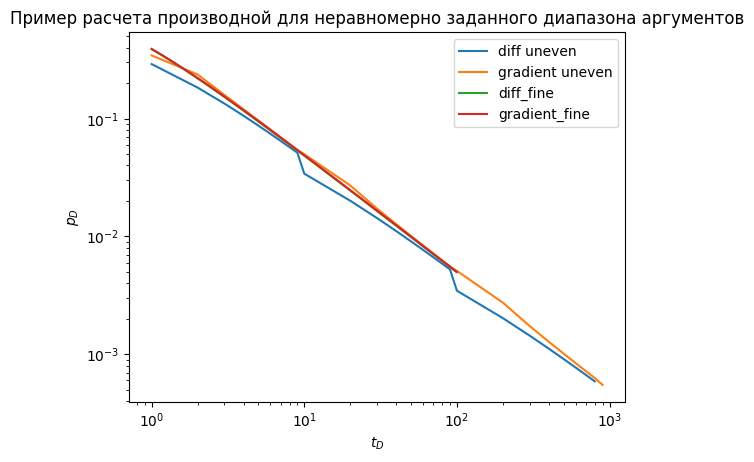

In [14]:
td1 = list(range(1,10,1)) + list(range(10,100,10)) + list(range(100,1000,100))

td = np.array(td1)
td_fine = np.logspace(0, 2, 300)
rr = 1

# при расчете разностей надо учесть, что длина массива уменьшится и убрать один элемент массива аргументов
plt.plot(td[:-1], np.diff(pd_ei(td))/np.diff(td), label='diff uneven')
plt.plot(td, np.gradient(pd_ei(td), td, edge_order=2), label='gradient uneven')
plt.plot(td_fine[:-1], np.diff(pd_ei(td_fine))/np.diff(td_fine), label='diff_fine')
plt.plot(td_fine, np.gradient(pd_ei(td_fine), td_fine, edge_order=2), label='gradient_fine')

plt.title("Пример расчета производной для неравномерно заданного диапазона аргументов")
plt.xlabel("$t_D$")
plt.ylabel("$p_D$")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


Построим разные варианты графиков с отображением безразмерного давления и производной 

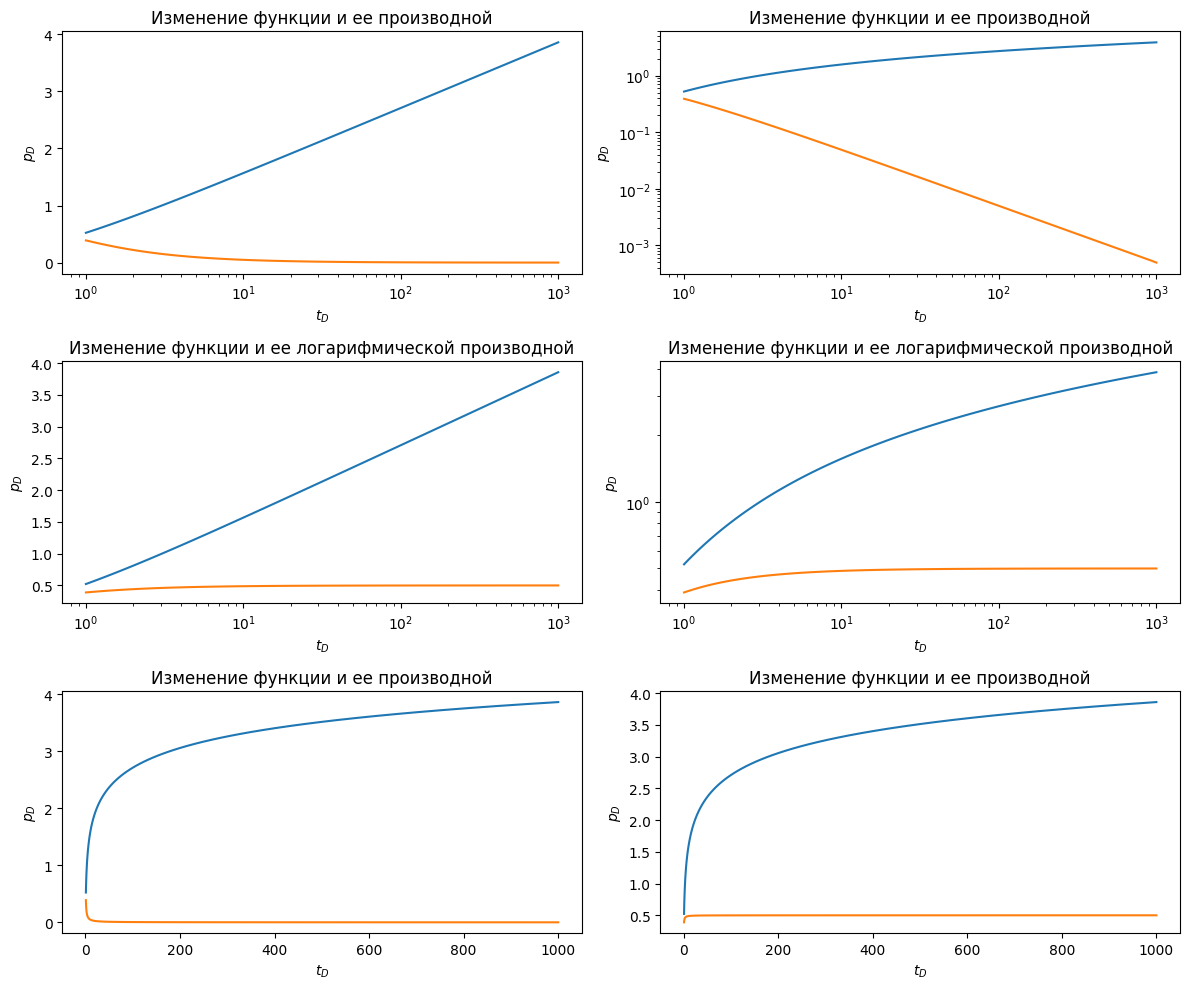

In [15]:
td = np.logspace(0, 3, 100)
rr = 1
pd = pd_ei(td)
dpd_dtd = np.gradient(pd_ei(td), td, edge_order=2)
dpd_dlntd = np.gradient(pd_ei(td), np.log(td), edge_order=2) 

fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].set_title("Изменение функции и ее производной")
ax[0,0].plot(td, pd_ei(td) )
ax[0,0].plot(td, dpd_dtd)
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel("$t_D$")
ax[0,0].set_ylabel("$p_D$")

ax[0,1].set_title("Изменение функции и ее производной")
ax[0,1].plot(td, pd_ei(td) )
ax[0,1].plot(td, dpd_dtd)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel("$t_D$")
ax[0,1].set_ylabel("$p_D$")

ax[1,0].set_title("Изменение функции и ее логарифмической производной")
ax[1,0].plot(td, pd_ei(td) )
ax[1,0].plot(td, dpd_dlntd)
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel("$t_D$")
ax[1,0].set_ylabel("$p_D$")

ax[1,1].set_title("Изменение функции и ее логарифмической производной")
ax[1,1].plot(td, pd_ei(td) )
ax[1,1].plot(td, dpd_dlntd)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel("$t_D$")
ax[1,1].set_ylabel("$p_D$")

ax[2,0].set_title("Изменение функции и ее производной")
ax[2,0].plot(td, pd_ei(td) )
ax[2,0].plot(td, dpd_dtd)
ax[2,0].set_xlabel("$t_D$")
ax[2,0].set_ylabel("$p_D$")

ax[2,1].set_title("Изменение функции и ее производной")
ax[2,1].plot(td, pd_ei(td) )
ax[2,1].plot(td, dpd_dlntd)
ax[2,1].set_xlabel("$t_D$")
ax[2,1].set_ylabel("$p_D$")

plt.tight_layout()
plt.show()

Интересно посмомотреть как выглядят только графики производной

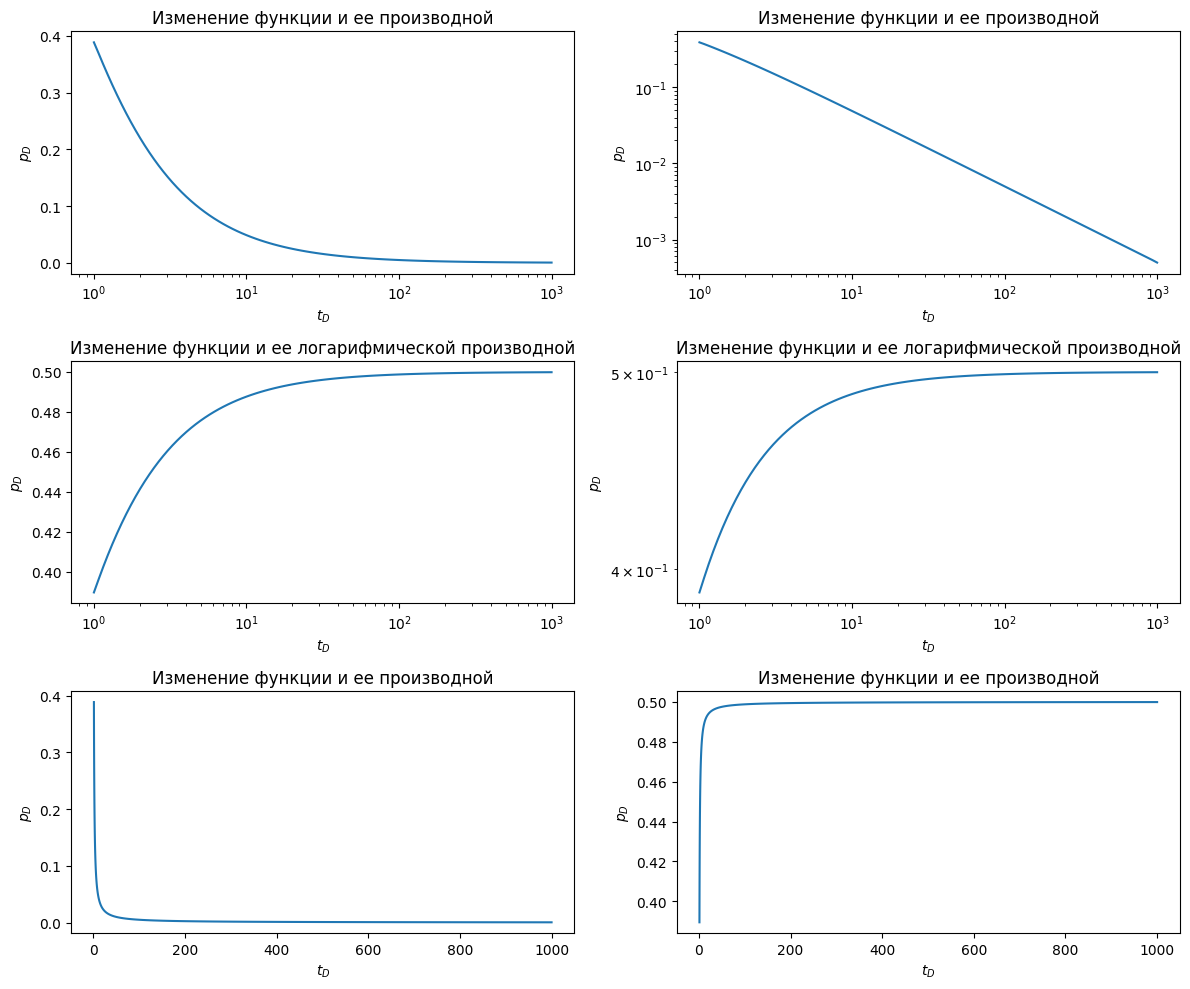

In [16]:

fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].set_title("Изменение функции и ее производной")
#ax[0,0].plot(td, pd_ei(td) )
ax[0,0].plot(td, dpd_dtd)
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel("$t_D$")
ax[0,0].set_ylabel("$p_D$")

ax[0,1].set_title("Изменение функции и ее производной")
#ax[0,1].plot(td, pd_ei(td) )
ax[0,1].plot(td, dpd_dtd)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel("$t_D$")
ax[0,1].set_ylabel("$p_D$")

ax[1,0].set_title("Изменение функции и ее логарифмической производной")
#ax[1,0].plot(td, pd_ei(td) )
ax[1,0].plot(td, dpd_dlntd)
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel("$t_D$")
ax[1,0].set_ylabel("$p_D$")

ax[1,1].set_title("Изменение функции и ее логарифмической производной")
#ax[1,1].plot(td, pd_ei(td) )
ax[1,1].plot(td, dpd_dlntd)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel("$t_D$")
ax[1,1].set_ylabel("$p_D$")

ax[2,0].set_title("Изменение функции и ее производной")
#ax[2,0].plot(td, pd_ei(td) )
ax[2,0].plot(td, dpd_dtd)
ax[2,0].set_xlabel("$t_D$")
ax[2,0].set_ylabel("$p_D$")

ax[2,1].set_title("Изменение функции и ее производной")
#ax[2,1].plot(td, pd_ei(td) )
ax[2,1].plot(td, dpd_dlntd)
ax[2,1].set_xlabel("$t_D$")
ax[2,1].set_ylabel("$p_D$")

plt.tight_layout()
plt.show()

График давления и его логарифмической производной в двойных логарифмических координатах представляет особый интерес для интерпретации гидродинамических исследований. Попробуйте ответить на вопрос - почему график логарифмической производной (почему это график логарифмической производной?) выглядит как прямая линии с нулевым наклоном для больших значений времен?

# 12.5. Задания для самостоятельной работы <a class="anchor" id="12.5"></a>

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте графики анализа чувствительности изменения давления на забое скважины после запуска для различных параметров скважины - проницаемости, вязкости, сжимаемости, пористости, скин-фактора. Какие параметры будут влиять на скорость изменения давления?

2. Сформулируйте критерии - как на графиках можно идентифицировать наличие радиального притока к скважине? Нарисуйте соответствующие графики выделив зоны по которым можно идентифицировать радиальный приток?
